In [1]:
import numpy as N
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime,timedelta
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import pandas as pd
import glob
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [2]:
# Function definitions
def interpnan1D(a):
    """Replaces NaN's in a 1D array by interpolating from good values on either side"""
    ind = N.where(~N.isnan(a))[0] # indices of valid values
    return N.interp(range(len(a)),ind,a[ind]) # Use valid values to interpolate to invalid values
def interpcircnan1D(a):
    """Replaces NaN's in a 1D array by interpolating from good values on either side (circular version for wind directions)"""
    ind = N.where(~N.isnan(a))[0] # indices of valid values
    a[ind] = N.unwrap(a[ind])
    a = N.mod(N.interp(range(len(a)),ind,a[ind]),360.)
    return a # N.interp(range(len(a)),ind,a[ind])
def computeuv(spd,wdir):
    u = spd*N.cos(N.deg2rad(-wdir+270.))
    v = spd*N.sin(N.deg2rad(-wdir+270.))
    return u,v
def computedir(u,v):
    wdir = 270.-(180./N.pi)*N.arctan2(v,u)
    return N.mod(wdir,360.)
def anglediffdeg(a,b):
    c = a - b
    return (c+180)%360-180

In [3]:
dis_dir = '/Users/ddawson/Dropbox/PIPS_data/processed/061416_061616/'
dis_files = glob.glob(dis_dir+'*.txt')
print dis_files

['/Users/ddawson/Dropbox/PIPS_data/processed/061416_061616/PIPS_1A_061416_061616_D1.txt', '/Users/ddawson/Dropbox/PIPS_data/processed/061416_061616/PIPS_1B_061416_061616_D1.txt', '/Users/ddawson/Dropbox/PIPS_data/processed/061416_061616/PIPS_2A_061416_061616_D1.txt', '/Users/ddawson/Dropbox/PIPS_data/processed/061416_061616/PIPS_2B_061416_061616_D1.txt']


In [4]:
windspds_series_list = []
winddirabss_series_list = []
fasttemps_series_list = []
slowtemps_series_list = []
dewpoints_series_list = []
RHs_series_list = []
pressures_series_list = []
compassdirs_series_list = []
PIPSnames = []
u_series_list = []
v_series_list = []
windspdsavgvec_series_list = []
winddirsavgvec_series_list = []
uavg_series_list = []
vavg_series_list = []

for dis_file in dis_files:
    datetimesUTC,pdatetimesUTC,flaggedtimes,intensities,preciptots,reflectivities,pcounts,pcounts2, \
           sensortemps,concentrations,onedrop_concentrations,countsMatrix,windspds,winddirrels,winddirabss, \
        winddiags,fasttemps,slowtemps,dewpoints,RHs_derived,RHs,pressures,compass_dirs,    \
        GPS_lats,GPS_lons,GPS_stats,GPS_alts,voltages,DSD_interval,DSD_intervalstr,DSD_index = dis.readPIPS(dis_file,rainonlyqc=False,DSD_interval=10.0)

    filename = os.path.split(dis_file)[1]
    PIPSname = filename[:7]
    PIPSnames.append(PIPSname)
        
    DSD_interval_td = timedelta(seconds=DSD_interval)
    DSD_halfinterval_td = timedelta(seconds=DSD_interval/2.)

    # Create pandas series' from the different observations
    
    windspds_series = pd.Series(windspds,index=datetimesUTC,name=PIPSname)
    windspds_series_list.append(windspds_series)
    
    winddirabss_series = pd.Series(winddirabss,index=datetimesUTC,name=PIPSname)
    winddirabss_series_list.append(winddirabss_series)
    
    u,v = computeuv(N.array(windspds),N.array(winddirabss))
    u_series = pd.Series(u,index=datetimesUTC,name=PIPSname)
    u_series_list.append(u_series)
    v_series = pd.Series(v,index=datetimesUTC,name=PIPSname)
    v_series_list.append(v_series)
    
    fasttemps_series = pd.Series(fasttemps,index=datetimesUTC,name=PIPSname)
    fasttemps_series_list.append(fasttemps_series)
    
    slowtemps_series = pd.Series(slowtemps,index=datetimesUTC,name=PIPSname)
    slowtemps_series_list.append(slowtemps_series)
    
    dewpoints_series = pd.Series(dewpoints,index=datetimesUTC,name=PIPSname)
    dewpoints_series_list.append(dewpoints_series)
    
    RHs_series = pd.Series(RHs,index=datetimesUTC,name=PIPSname)
    RHs_series_list.append(RHs_series)
    
    pressures_series = pd.Series(pressures,index=datetimesUTC,name=PIPSname)
    pressures_series_list.append(pressures_series)
    
    compassdirs_series = pd.Series(compass_dirs,index=datetimesUTC,name=PIPSname)
    compassdirs_series_list.append(compassdirs_series)
    

# Now, join the separate series' into Dataframes, using only the common times for each.
windspds_df = pd.concat(windspds_series_list,join='inner',axis=1)
winddirabss_df = pd.concat(winddirabss_series_list,join='inner',axis=1)
u_df = pd.concat(u_series_list,join='inner',axis=1)
v_df = pd.concat(v_series_list,join='inner',axis=1)
fasttemps_df = pd.concat(fasttemps_series_list,join='inner',axis=1)
slowtemps_df = pd.concat(slowtemps_series_list,join='inner',axis=1)
dewpoints_df = pd.concat(dewpoints_series_list,join='inner',axis=1)
RHs_df = pd.concat(RHs_series_list,join='inner',axis=1)
pressures_df = pd.concat(pressures_series_list,join='inner',axis=1)
compassdirs_df = pd.concat(compassdirs_series_list,join='inner',axis=1)

140616 133028
2016-06-14 13:30:28
2016 6 14 13 30 28
2016-06-14 13:30:28 2016-06-14 13:30:28
GPS Offset 0:00:00
Requested DSD interval: 10.0. Actual DSD interval: 10.0
140616 133628
2016-06-14 13:36:28
2016 6 14 13 36 28
2016-06-14 13:36:28 2016-06-14 13:36:28
GPS Offset 0:00:00
Requested DSD interval: 10.0. Actual DSD interval: 10.0
140616 134357
2016-06-14 13:43:57
2016 6 14 13 43 57
2016-06-14 13:43:57 2016-06-14 13:43:57
GPS Offset 0:00:00
Requested DSD interval: 10.0. Actual DSD interval: 10.0
140616 134834
2016-06-14 13:48:34
2016 6 14 13 48 34
2016-06-14 13:48:34 2016-06-14 13:48:34
GPS Offset 0:00:00
Requested DSD interval: 10.0. Actual DSD interval: 10.0


In [ ]:
compassdirs_df.plot(figsize=(10,6))

In [10]:
# Create time averages of the data
avginterval = 900 # seconds
offset = 0
intervalstr = '{:d}S'.format(avginterval)
fasttempsavg_series_list = []
slowtempsavg_series_list = []
dewpointsavg_series_list = []
RHsavg_series_list = []
pressuresavg_series_list = []
fasttemps_series_list = []
windspdsavgvec_series_list = []
winddirsavgvec_series_list = []
winddirsunitavgvec_series_list = []
uavg_series_list = []
vavg_series_list = []
unit_uavg_series_list = []
unit_vavg_series_list = []
index = fasttemps_df.index

for PIPSname in PIPSnames:
    fasttemps = N.array(fasttemps_df[PIPSname].values)
    slowtemps = N.array(slowtemps_df[PIPSname].values)
    dewpoints = N.array(dewpoints_df[PIPSname].values)
    RHs = N.array(RHs_df[PIPSname].values)
    pressures = N.array(pressures_df[PIPSname].values)
    winddirabss = N.array(winddirabss_df[PIPSname].values)
    windspds = N.array(windspds_df[PIPSname].values)
    
    fasttempsavg_series = pd.Series(data=fasttemps,index=index,name=PIPSname).resample(intervalstr,label='right',closed='right',base=offset).mean()
    fasttempsavg_series_list.append(fasttempsavg_series)
    slowtempsavg_series = pd.Series(data=slowtemps,index=index,name=PIPSname).resample(intervalstr,label='right',closed='right',base=offset).mean()
    slowtempsavg_series_list.append(slowtempsavg_series)
    dewpointsavg_series = pd.Series(data=dewpoints,index=index,name=PIPSname).resample(intervalstr,label='right',closed='right',base=offset).mean()
    dewpointsavg_series_list.append(dewpointsavg_series)
    RHsavg_series = pd.Series(data=RHs,index=index,name=PIPSname).resample(intervalstr,label='right',closed='right',base=offset).mean()
    RHsavg_series_list.append(RHsavg_series)
    pressuresavg_series = pd.Series(data=pressures,index=index,name=PIPSname).resample(intervalstr,label='right',closed='right',base=offset).mean()
    pressuresavg_series_list.append(pressuresavg_series)
    
    windspdsavg_series,windspdsavgvec_series,winddirsavgvec_series, \
    winddirsunitavgvec_series,windgusts_series,windgustsavg_series,uavg_series,vavg_series,unit_uavg_series,unit_vavg_series = \
        dis.resamplewind(index,offset,winddirabss,windspds,intervalstr,gusts=True, \
                         gustintvstr='3S',center=False)
    windspdsavgvec_series.name=PIPSname
    windspdsavgvec_series_list.append(windspdsavgvec_series)
    winddirsavgvec_series.name=PIPSname
    winddirsavgvec_series_list.append(winddirsavgvec_series)
    #uavg,vavg = computeuv(N.array(windspdsavgvec_series.values),N.array(winddirsavgvec_series.values))
#     u,v = computeuv(N.array(windspds),N.array(winddirabss))
#     uavg_series = pd.Series(data=u,index=index,name=PIPSname).resample(intervalstr,label='right',closed='right',base=offset).mean()
#     vavg_series = pd.Series(data=v,index=index,name=PIPSname).resample(intervalstr,label='right',closed='right',base=offset).mean()
    uavg_series.name=PIPSname
    vavg_series.name=PIPSname
    unit_uavg_series.name=PIPSname
    unit_vavg_series.name=PIPSname
    winddirsunitavgvec_series.name=PIPSname
    uavg_series_list.append(uavg_series)
    vavg_series_list.append(vavg_series)
    unit_uavg_series_list.append(unit_uavg_series)
    unit_vavg_series_list.append(unit_vavg_series)
    winddirsunitavgvec_series_list.append(winddirsunitavgvec_series)
    
# Now, join the separate series' into Dataframes, using only the common times for each.
fasttempsavg_df = pd.concat(fasttempsavg_series_list,join='inner',axis=1)
slowtempsavg_df = pd.concat(slowtempsavg_series_list,join='inner',axis=1)
dewpointsavg_df = pd.concat(dewpointsavg_series_list,join='inner',axis=1)
RHsavg_df = pd.concat(RHsavg_series_list,join='inner',axis=1)
pressuresavg_df = pd.concat(pressuresavg_series_list,join='inner',axis=1)
winddirsavgvec_df = pd.concat(winddirsavgvec_series_list,join='inner',axis=1)
windspdsavgvec_df = pd.concat(windspdsavgvec_series_list,join='inner',axis=1)
winddirsunitavgvec_df = pd.concat(winddirsunitavgvec_series_list,join='inner',axis=1)
uavg_df = pd.concat(uavg_series_list,join='inner',axis=1)
vavg_df = pd.concat(vavg_series_list,join='inner',axis=1)
unit_uavg_df = pd.concat(unit_uavg_series_list,join='inner',axis=1)
unit_vavg_df = pd.concat(unit_vavg_series_list,join='inner',axis=1)

In [ ]:
windspds_df.plot(figsize=(10,6))
winddirabss_df.plot(figsize=(10,6))
fasttemps_df.plot(figsize=(10,6))
slowtemps_df.plot(figsize=(10,6))
dewpoints_df.plot(figsize=(10,6))
RHs_df.plot(figsize=(10,6))
pressures_df.plot(figsize=(10,6))
u_df.plot(figsize=(10,6))
v_df.plot(figsize=(10,6))
uavg_df.plot(figsize=(10,6))
vavg_df.plot(figsize=(10,6))

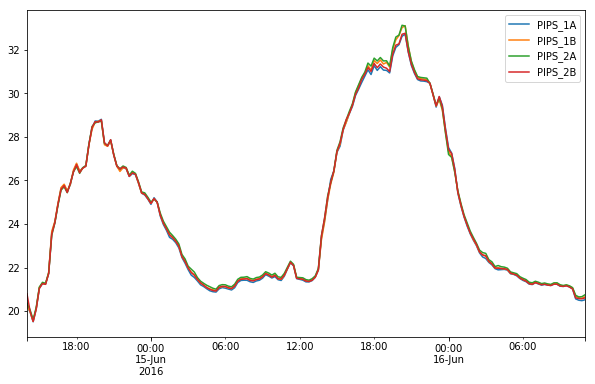

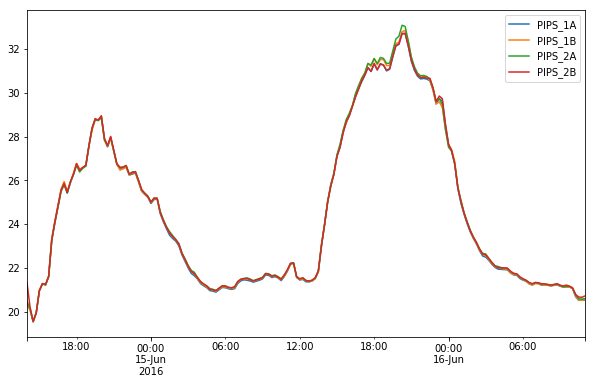

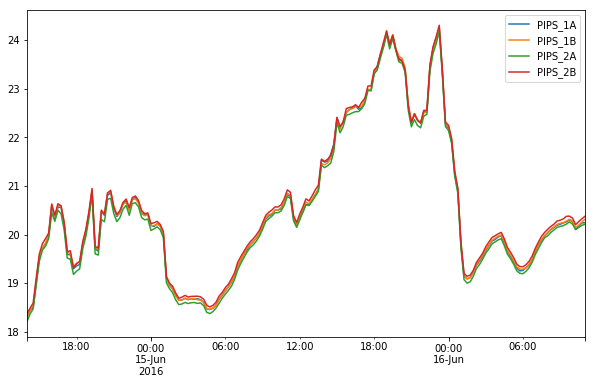

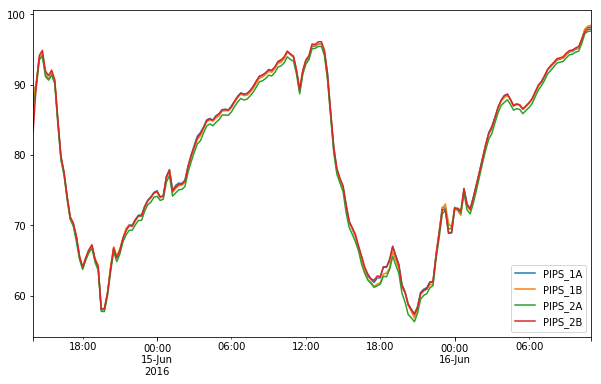

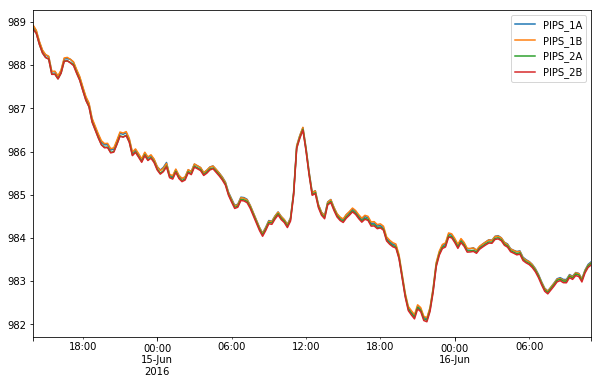

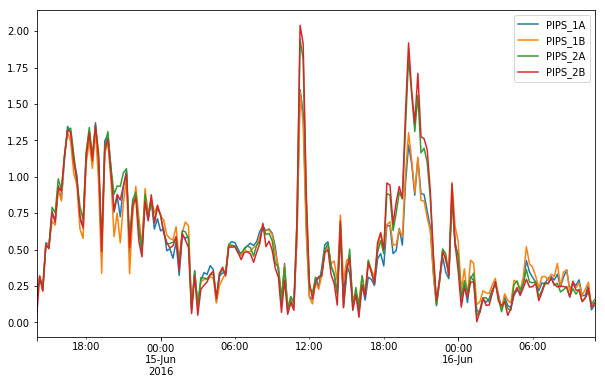

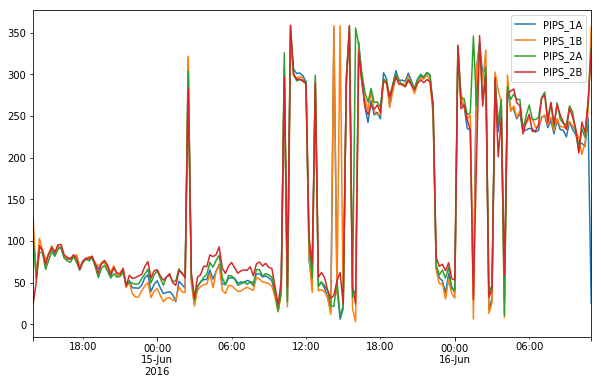

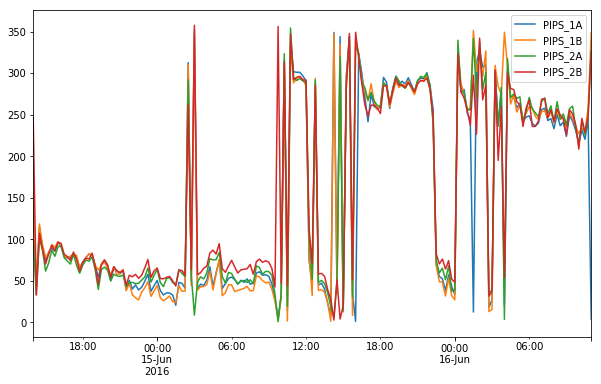

In [11]:
fasttempsavg_df.plot(figsize=(10,6))
slowtempsavg_df.plot(figsize=(10,6))
dewpointsavg_df.plot(figsize=(10,6))
RHsavg_df.plot(figsize=(10,6))
pressuresavg_df.plot(figsize=(10,6))
windspdsavgvec_df.plot(figsize=(10,6))
winddirsavgvec_df.plot(figsize=(10,6))
winddirsunitavgvec_df.plot(figsize=(10,6))

In [ ]:
# Compute bias of the PIPS observations as a function of time
fasttemps_mean_df = fasttemps_df.mean(axis=1)
fasttemps_bias_df = fasttemps_df.copy()
fasttemps_bias_df['PIPS_1A']=fasttemps_df['PIPS_1A']-fasttemps_mean_df
fasttemps_bias_df['PIPS_1B']=fasttemps_df['PIPS_1B']-fasttemps_mean_df
fasttemps_bias_df['PIPS_2A']=fasttemps_df['PIPS_2A']-fasttemps_mean_df
fasttemps_bias_df['PIPS_2B']=fasttemps_df['PIPS_2B']-fasttemps_mean_df
fasttemps_bias = fasttemps_bias_df.mean(axis=0)
print "Fast temps bias"
print fasttemps_bias

RHs_mean_df = RHs_df.mean(axis=1)
RHs_bias_df = RHs_df.copy()
RHs_bias_df['PIPS_1A']=RHs_df['PIPS_1A']-RHs_mean_df
RHs_bias_df['PIPS_1B']=RHs_df['PIPS_1B']-RHs_mean_df
RHs_bias_df['PIPS_2A']=RHs_df['PIPS_2A']-RHs_mean_df
RHs_bias_df['PIPS_2B']=RHs_df['PIPS_2B']-RHs_mean_df
RHs_bias = RHs_bias_df.mean(axis=0)
print "RH bias"
print RHs_bias

pressures_mean_df = pressures_df.mean(axis=1)
pressures_bias_df = pressures_df.copy()
pressures_bias_df['PIPS_1A']=pressures_df['PIPS_1A']-pressures_mean_df
pressures_bias_df['PIPS_1B']=pressures_df['PIPS_1B']-pressures_mean_df
pressures_bias_df['PIPS_2A']=pressures_df['PIPS_2A']-pressures_mean_df
pressures_bias_df['PIPS_2B']=pressures_df['PIPS_2B']-pressures_mean_df
pressures_bias = pressures_bias_df.mean(axis=0)
print "pressure bias"
print pressures_bias

u_mean_df = u_df.mean(axis=1)
u_bias_df = u_df.copy()
u_bias_df['PIPS_1A']=u_df['PIPS_1A']-u_mean_df
u_bias_df['PIPS_1B']=u_df['PIPS_1B']-u_mean_df
u_bias_df['PIPS_2A']=u_df['PIPS_2A']-u_mean_df
u_bias_df['PIPS_2B']=u_df['PIPS_2B']-u_mean_df
u_bias = u_bias_df.mean(axis=0)
print "u wind bias"
print u_bias

v_mean_df = v_df.mean(axis=1)
v_bias_df = v_df.copy()
v_bias_df['PIPS_1A']=v_df['PIPS_1A']-v_mean_df
v_bias_df['PIPS_1B']=v_df['PIPS_1B']-v_mean_df
v_bias_df['PIPS_2A']=v_df['PIPS_2A']-v_mean_df
v_bias_df['PIPS_2B']=v_df['PIPS_2B']-v_mean_df
v_bias = v_bias_df.mean(axis=0)
print "v wind bias"
print v_bias

winddir_mean_df = computedir(u_mean_df,v_mean_df)
winddir_bias_df = winddirabss_df.copy()
# winddir_bias_df['PIPS_1A']=winddirabss_df['PIPS_1A']-winddir_mean_df
# winddir_bias_df['PIPS_1B']=winddirabss_df['PIPS_1B']-winddir_mean_df
# winddir_bias_df['PIPS_2A']=winddirabss_df['PIPS_2A']-winddir_mean_df
# winddir_bias_df['PIPS_2B']=winddirabss_df['PIPS_2B']-winddir_mean_df
winddir_bias_df['PIPS_1A']=anglediffdeg(winddirabss_df['PIPS_1A'],winddir_mean_df)
winddir_bias_df['PIPS_1B']=anglediffdeg(winddirabss_df['PIPS_1B'],winddir_mean_df)
winddir_bias_df['PIPS_2A']=anglediffdeg(winddirabss_df['PIPS_2A'],winddir_mean_df)
winddir_bias_df['PIPS_2B']=anglediffdeg(winddirabss_df['PIPS_2B'],winddir_mean_df)
winddir_bias = winddir_bias_df.mean(axis=0)
print "wind direction bias"
print winddir_bias

windspds_mean_df = windspds_df.mean(axis=1) # Note, this is *scalar* mean
windspds_bias_df = windspds_df.copy()
windspds_bias_df['PIPS_1A']=windspds_df['PIPS_1A']-windspds_mean_df
windspds_bias_df['PIPS_1B']=windspds_df['PIPS_1B']-windspds_mean_df
windspds_bias_df['PIPS_2A']=windspds_df['PIPS_2A']-windspds_mean_df
windspds_bias_df['PIPS_2B']=windspds_df['PIPS_2B']-windspds_mean_df
windspds_bias = windspds_bias_df.mean(axis=0)
print "windspeed bias"
print windspds_bias

In [13]:
# Compute bias of the time-resampled PIPS observations as a function of time
fasttempsavg_mean_df = fasttempsavg_df.mean(axis=1)
fasttempsavg_bias_df = fasttempsavg_df.copy()
fasttempsavg_bias_df['PIPS_1A']=fasttempsavg_df['PIPS_1A']-fasttempsavg_mean_df
fasttempsavg_bias_df['PIPS_1B']=fasttempsavg_df['PIPS_1B']-fasttempsavg_mean_df
fasttempsavg_bias_df['PIPS_2A']=fasttempsavg_df['PIPS_2A']-fasttempsavg_mean_df
fasttempsavg_bias_df['PIPS_2B']=fasttempsavg_df['PIPS_2B']-fasttempsavg_mean_df
fasttempsavg_bias = fasttempsavg_bias_df.mean(axis=0)
print "Resampled fast temps bias"
print fasttempsavg_bias

RHsavg_mean_df = RHsavg_df.mean(axis=1)
RHsavg_bias_df = RHsavg_df.copy()
RHsavg_bias_df['PIPS_1A']=RHsavg_df['PIPS_1A']-RHsavg_mean_df
RHsavg_bias_df['PIPS_1B']=RHsavg_df['PIPS_1B']-RHsavg_mean_df
RHsavg_bias_df['PIPS_2A']=RHsavg_df['PIPS_2A']-RHsavg_mean_df
RHsavg_bias_df['PIPS_2B']=RHsavg_df['PIPS_2B']-RHsavg_mean_df
RHsavg_bias = RHsavg_bias_df.mean(axis=0)
print "Resampled RH bias"
print RHsavg_bias

pressuresavg_mean_df = pressuresavg_df.mean(axis=1)
pressuresavg_bias_df = pressuresavg_df.copy()
pressuresavg_bias_df['PIPS_1A']=pressuresavg_df['PIPS_1A']-pressuresavg_mean_df
pressuresavg_bias_df['PIPS_1B']=pressuresavg_df['PIPS_1B']-pressuresavg_mean_df
pressuresavg_bias_df['PIPS_2A']=pressuresavg_df['PIPS_2A']-pressuresavg_mean_df
pressuresavg_bias_df['PIPS_2B']=pressuresavg_df['PIPS_2B']-pressuresavg_mean_df
pressuresavg_bias = pressuresavg_bias_df.mean(axis=0)
print "Resampled pressure bias"
print pressuresavg_bias

uavg_mean_df = uavg_df.mean(axis=1) # *should* be the same as u_df.mean(axis=1)
vavg_mean_df = vavg_df.mean(axis=1)
uavg_bias_df = uavg_df.copy()
uavg_bias_df['PIPS_1A']=uavg_df['PIPS_1A']-uavg_mean_df
uavg_bias_df['PIPS_1B']=uavg_df['PIPS_1B']-uavg_mean_df
uavg_bias_df['PIPS_2A']=uavg_df['PIPS_2A']-uavg_mean_df
uavg_bias_df['PIPS_2B']=uavg_df['PIPS_2B']-uavg_mean_df
uavg_bias = uavg_bias_df.mean(axis=0)
print "Resampled u-wind bias"
print uavg_bias

vavg_bias_df = vavg_df.copy()
vavg_bias_df['PIPS_1A']=vavg_df['PIPS_1A']-vavg_mean_df
vavg_bias_df['PIPS_1B']=vavg_df['PIPS_1B']-vavg_mean_df
vavg_bias_df['PIPS_2A']=vavg_df['PIPS_2A']-vavg_mean_df
vavg_bias_df['PIPS_2B']=vavg_df['PIPS_2B']-vavg_mean_df
vavg_bias = vavg_bias_df.mean(axis=0)
print "Resampled v-wind bias"
print vavg_bias

winddiravgvec_mean_df = computedir(uavg_mean_df,vavg_mean_df)
winddiravgvec_bias_df = winddirsavgvec_df.copy()
# winddiravgvec_bias_df['PIPS_1A']=winddirsavgvec_df['PIPS_1A']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_1B']=winddirsavgvec_df['PIPS_1B']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_2A']=winddirsavgvec_df['PIPS_2A']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_2B']=winddirsavgvec_df['PIPS_2B']-winddiravgvec_mean_df
winddiravgvec_bias_df['PIPS_1A']=anglediffdeg(winddirsavgvec_df['PIPS_1A'],winddiravgvec_mean_df)
winddiravgvec_bias_df['PIPS_1B']=anglediffdeg(winddirsavgvec_df['PIPS_1B'],winddiravgvec_mean_df)
winddiravgvec_bias_df['PIPS_2A']=anglediffdeg(winddirsavgvec_df['PIPS_2A'],winddiravgvec_mean_df)
winddiravgvec_bias_df['PIPS_2B']=anglediffdeg(winddirsavgvec_df['PIPS_2B'],winddiravgvec_mean_df)
winddiravgvec_bias = winddiravgvec_bias_df.mean(axis=0)
print "Resampled wind direction bias"
print winddiravgvec_bias

unit_uavg_mean_df = unit_uavg_df.mean(axis=1)
unit_vavg_mean_df = unit_vavg_df.mean(axis=1)
winddirunitavgvec_mean_df = computedir(unit_uavg_mean_df,unit_vavg_mean_df)
winddirunitavgvec_bias_df = winddirsunitavgvec_df.copy()
# winddiravgvec_bias_df['PIPS_1A']=winddirsavgvec_df['PIPS_1A']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_1B']=winddirsavgvec_df['PIPS_1B']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_2A']=winddirsavgvec_df['PIPS_2A']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_2B']=winddirsavgvec_df['PIPS_2B']-winddiravgvec_mean_df
winddirunitavgvec_bias_df['PIPS_1A']=anglediffdeg(winddirsunitavgvec_df['PIPS_1A'],winddirunitavgvec_mean_df)
winddirunitavgvec_bias_df['PIPS_1B']=anglediffdeg(winddirsunitavgvec_df['PIPS_1B'],winddirunitavgvec_mean_df)
winddirunitavgvec_bias_df['PIPS_2A']=anglediffdeg(winddirsunitavgvec_df['PIPS_2A'],winddirunitavgvec_mean_df)
winddirunitavgvec_bias_df['PIPS_2B']=anglediffdeg(winddirsunitavgvec_df['PIPS_2B'],winddirunitavgvec_mean_df)
winddirunitavgvec_bias = winddirunitavgvec_bias_df.mean(axis=0)
print "Resampled unit wind direction bias"
print winddirunitavgvec_bias

windspdsavgvec_mean_df = windspdsavgvec_df.mean(axis=1)
windspdsavgvec_bias_df = windspdsavgvec_df.copy()
windspdsavgvec_bias_df['PIPS_1A']=windspdsavgvec_df['PIPS_1A']-windspdsavgvec_mean_df
windspdsavgvec_bias_df['PIPS_1B']=windspdsavgvec_df['PIPS_1B']-windspdsavgvec_mean_df
windspdsavgvec_bias_df['PIPS_2A']=windspdsavgvec_df['PIPS_2A']-windspdsavgvec_mean_df
windspdsavgvec_bias_df['PIPS_2B']=windspdsavgvec_df['PIPS_2B']-windspdsavgvec_mean_df
windspdsavgvec_bias = windspdsavgvec_bias_df.mean(axis=0)
print "Resampled windspeed bias"
print windspdsavgvec_bias

Resampled fast temps bias
PIPS_1A   -0.051293
PIPS_1B    0.004831
PIPS_2A    0.058351
PIPS_2B   -0.011890
dtype: float64
Resampled RH bias
PIPS_1A    0.194223
PIPS_1B    0.064148
PIPS_2A   -0.468332
PIPS_2B    0.209961
dtype: float64
Resampled pressure bias
PIPS_1A    0.026018
PIPS_1B    0.034285
PIPS_2A   -0.018176
PIPS_2B   -0.042127
dtype: float64
Resampled u-wind bias
PIPS_1A   -0.022591
PIPS_1B    0.017374
PIPS_2A    0.000484
PIPS_2B    0.004733
dtype: float64
Resampled v-wind bias
PIPS_1A    0.001670
PIPS_1B   -0.014855
PIPS_2A   -0.018320
PIPS_2B    0.031505
dtype: float64
Resampled wind direction bias
PIPS_1A   -1.548108
PIPS_1B   -3.751704
PIPS_2A    1.883422
PIPS_2B    3.765886
dtype: float64
Resampled unit wind direction bias
PIPS_1A   -1.189249
PIPS_1B   -3.295935
PIPS_2A    1.019235
PIPS_2B    3.869242
dtype: float64
Resampled windspeed bias
PIPS_1A   -0.020428
PIPS_1B   -0.008451
PIPS_2A    0.021740
PIPS_2B    0.007140
dtype: float64


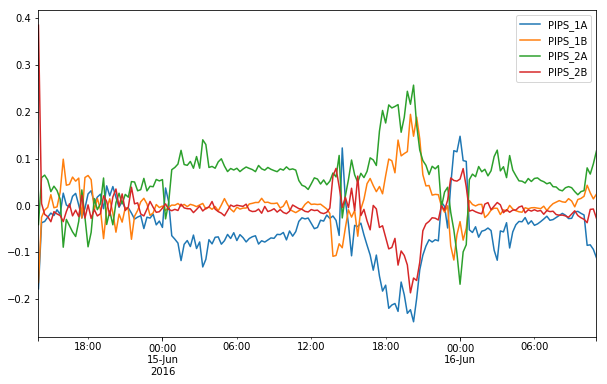

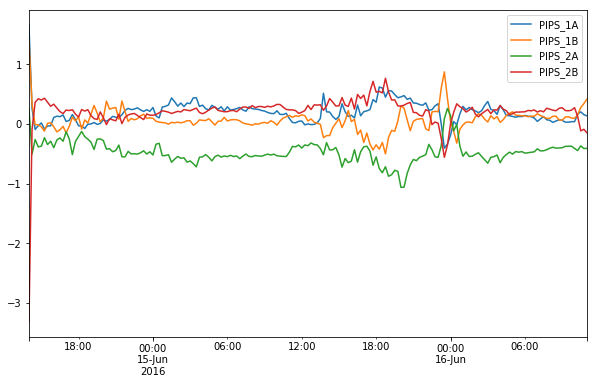

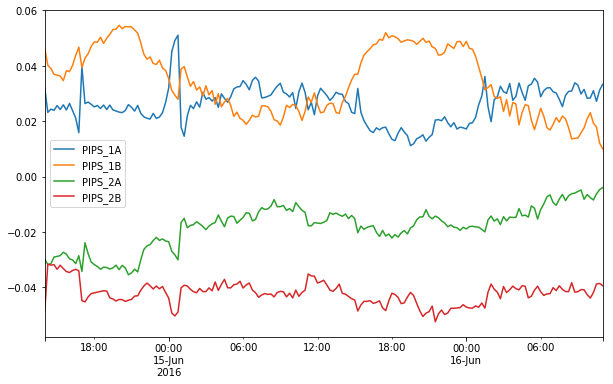

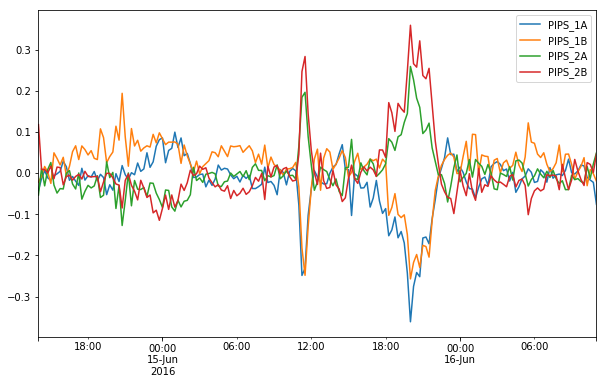

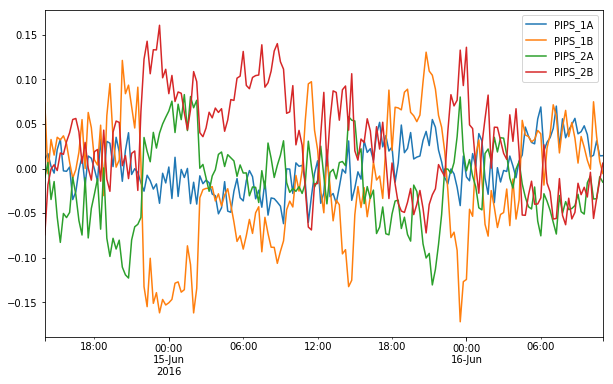

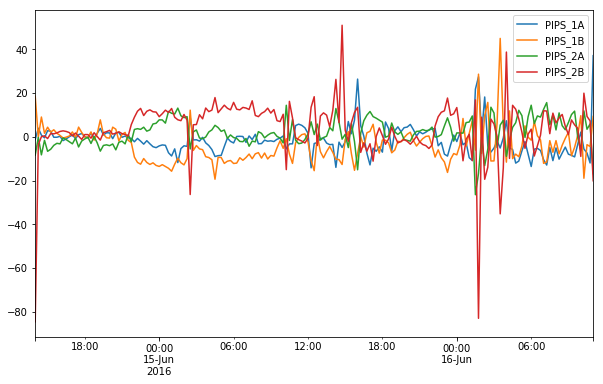

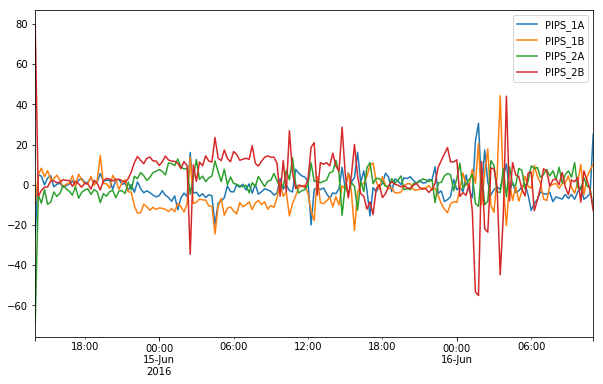

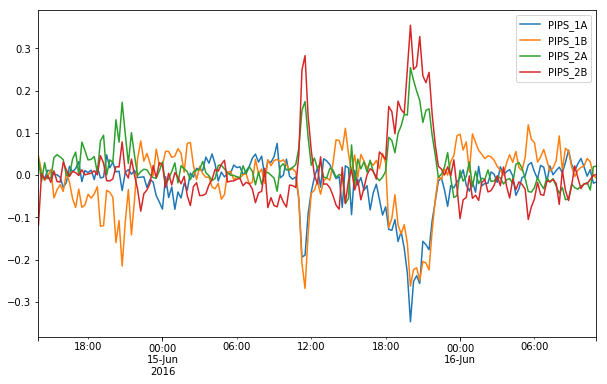

In [14]:
fasttempsavg_bias_df.plot(figsize=(10,6))
RHsavg_bias_df.plot(figsize=(10,6))
pressuresavg_bias_df.plot(figsize=(10,6))
uavg_bias_df.plot(figsize=(10,6))
vavg_bias_df.plot(figsize=(10,6))
winddiravgvec_bias_df.plot(figsize=(10,6))
winddirunitavgvec_bias_df.plot(figsize=(10,6))
windspdsavgvec_bias_df.plot(figsize=(10,6))

In [ ]:
# Scratch code below, don't execute!
    
    # Convert to numpy arrays
    windspds = N.array(windspds)
    winddirrels = N.array(winddirrels)
    winddirabss = N.array(winddirabss)
    fasttemps = N.array(fasttemps)
    slowtemps = N.array(slowtemps)
    dewpoints = N.array(dewpoints)
    RHs_derived = N.array(RHs_derived)
    RHs = N.array(RHs)
    pressures = N.array(pressures)
    pcounts = N.array(pcounts)
    pcounts2 = N.array(pcounts2)
    intensities = N.array(intensities)

    Nc_bin = concentrations.T
    dropperbin = onedrop_concentrations.T

    logNc_bin = N.ma.log10(Nc_bin)
    logNc_bin = N.ma.masked_where(Nc_bin < dropperbin, logNc_bin)

    # Compute potential temperature, water vapor mixing ratio, and density
    pt = thermo.caltheta(pressures*100.,slowtemps+273.15)
    qv = thermo.calqv(RHs/100.,pressures*100.,slowtemps+273.15)
    rho=thermo.calrho(pressures*100.,pt,qv)